# Fluorescence Correlation Spectroscopy (FCS)

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("white")
import image_analysis as anl #function file for all sorts of image analysis
#from https://github.com/shivChitinous/image-annals
plt.rcParams["animation.html"] = "jshtml"
from celluloid import Camera
import multipletau as mt #for calculating the autocorrelation function

### 1. Random Walks
To understand FCS, we can simulate the movement of fluorescent particles as a gaussian random walk in 2D. To do this we'll create a $5 \mu \text{m}$ x $5 \mu \text{m}$ grid on which $N$ particles diffuse with a diffusion coefficient $D_f$. We assume periodic boundary conditions.

### 2. Autocorrelation
Given information about the position of the molecules at every time point, we can simulate fluorescence confocal images for a small region on the grid. The values of each pixel in this field of view (FOV) will constitute a fluorescence signal that can be used to derive the autocorrelation function $G$. We can then ask how $G$ varies with $N$ or $D_f$.

In [2]:
## HIDDEN
figfile = "fcs_figs/"

## Simulating Random Walks
First we need to define a function `diffuse` that gives us a simulated video of the FOV over a certain number of frames. To generate artificial images we will use standard optical parameters.

In [3]:
def diffuse(N,Df,T,
            B=5, #box size in um
            scale_true=5, #in nm/pixel (size of the protein is 5nm = 1pix)
            lam=500, #in nm - wavelength of light
            ccd_scale=100, #in nm/pixel
            fr=10000, #frame rate in frames per second
            SNr=10, #signal to noise
            bkg=10 #background noise
           ):
    
    #calibrating SI to pixels and frames:
    T = int(T*fr) #T is now number of frames
    B = B*1e3/(2*scale_true) #B is now box half width in number of pixels
    Df = Df*((1e3/scale_true)**2)/fr #Df is now in pixel^2 per frame
    
    x = (np.random.rand(N,T)-0.5)*2*B #uniformly distribute the particles at t=0
    y = (np.random.rand(N,T)-0.5)*2*B
    vid = np.zeros([10,10,T])
    
    for i in range(T):
        x[:,i] = x[:,i-1]+(np.random.normal(loc=0, scale=np.sqrt(2*Df), size=(1,N))) #random walk
        y[:,i] = y[:,i-1]+(np.random.normal(loc=0, scale=np.sqrt(2*Df), size=(1,N)))
        x[x>B] = x[x>B]-2*B; x[x<-B] = x[x<-B]+2*B #periodic boundaries
        y[y>B] = y[y>B]-2*B; y[y<-B] = y[y<-B]+2*B

        #creating a blank frame
        pic = np.zeros([201,201])

        #getting all particles within the FOV at time t
        condition = ~(((x[:,i]>200) | (x[:,i]<0))|((y[:,i]>200) | (y[:,i]<0)))
        xp = x[:,i][condition]; yp = y[:,i][condition]

        #getting all the pixel values of the 'true image'
        pix = np.vstack([np.round(xp).astype('int'),np.round(yp).astype('int')]).T
        loc,counts = np.unique(pix,axis=0,return_counts=True)

        #setting the right pixel values to bright
        pic[loc[:,0],loc[:,1]] = counts

        #capture frame
        vid[:,:,i] = anl.simulator(pic,scale_true,lam,ccd_scale,SNr,bkg)
    return vid

To simulate randomly walking molecules we need to know the number of diffusing particles $(N)$, the time for which you want to record the video $(T)$ and the diffusion constant of the particles ($D_f$).

In [4]:
N = 100 #number of particles
Df = 10 #in micrometer^2/s
T = 0.01 #in seconds

In [5]:
vid = diffuse(N,Df,T)

In [6]:
## HIDDEN
fig = plt.figure(figsize = (4.5,4.5))
camera = Camera(fig)
for i in range(np.shape(vid)[2]):
    plt.imshow(vid[:,:,i],cmap = 'gray',vmin=0,vmax=256)
    camera.snap()
plt.close()

In [7]:
## HIDDEN
animation = camera.animate()
animation.save(figfile+"single_particle_diffusion.gif",writer = 'imagemagick',fps = 10,dpi=300)
animation

## Deriving the Autocorrelation Function

In [8]:
vid = diffuse(100,10,0.5)

In [9]:
pix = vid.reshape(np.size(vid[:,:,0]),np.shape(vid)[2])

Let's plot the values of a single pixel.

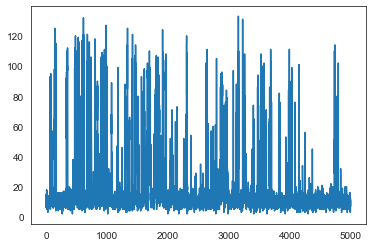

In [10]:
plt.plot(pix[99]);

We can derive the autocorrelation function $G(\tau)$ for every pixel in the FOV.

In [11]:
G = np.zeros(np.size(vid[:,:,0]),dtype='object')
for p in range(np.size(vid[:,:,0])):
    G[p] = mt.autocorrelate(pix[p],m=10,normalize=True)

Let's plot the mean $G(\tau)$ for the FOV.

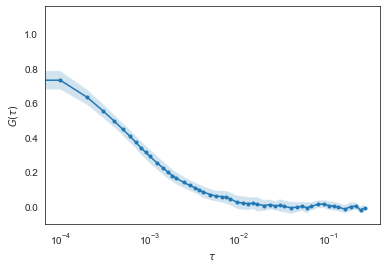

In [12]:
## HIDDEN
fr = 10000 #frames/sec
plt.xscale('log')
plt.plot(np.mean(G)[:,0]/fr,np.mean(G)[:,1],'.-')
plt.fill_between(np.mean(G)[:,0]/fr, np.mean(G)[:,1]-np.std(G)[:,1], np.mean(G)[:,1]+np.std(G)[:,1], alpha=.2)
plt.xlabel(r'$\tau$'); plt.ylabel(r'$G(\tau)$')
plt.savefig(figfile+"sample_G_tau.png",dpi=300);

## How does the autocorrelation function vary with $N$?

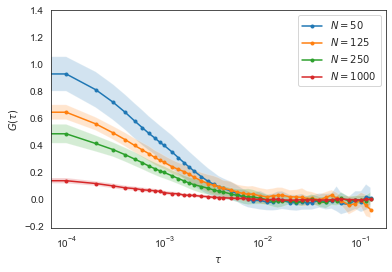

In [13]:
## HIDDEN
plt.figure(figsize=(6,4))
plt.xscale('log')
N = np.array([50,125,250,1000])
for n in N:
    vid = diffuse(n,10,0.2)
    pix = vid.reshape(np.size(vid[:,:,0]),np.shape(vid)[2])
    G = np.zeros(np.size(vid[:,:,0]),dtype='object')
    for p in range(np.size(vid[:,:,0])):
        G[p] = mt.autocorrelate(pix[p],m=10,normalize=True)
    fr = 10000 #frames/sec
    plt.plot(np.mean(G)[:,0]/fr,np.mean(G)[:,1],'.-')
    plt.fill_between(np.mean(G)[:,0]/fr, np.mean(G)[:,1]-np.std(G)[:,1], np.mean(G)[:,1]+np.std(G)[:,1], alpha=.2)
plt.legend('$N = '+N.astype('str').astype('object')+'$')
plt.xlabel(r'$\tau$'); plt.ylabel(r'$G(\tau)$')
plt.savefig(figfile+"G_tau_varying_N.png",dpi=300);

As the number of particles within the box grows, the maximum value of $G(\tau)$ goes down. This is because the self-similarity within the signal is more prominent when a single particle occupies a small region. If there are many particles, the photons from a single particle will be masked by the noise from the surrounding particles.

## How does the autocorrelation function vary with $D_f$?

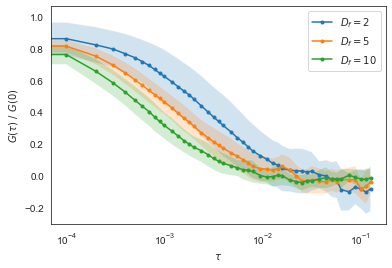

In [14]:
## HIDDEN
plt.figure(figsize=(6,4))
plt.xscale('log')
Df = np.array([2,5,10])
for df in Df:
    vid = diffuse(100,df,0.2)
    pix = vid.reshape(np.size(vid[:,:,0]),np.shape(vid)[2])
    G = np.zeros(np.size(vid[:,:,0]),dtype='object')
    for p in range(np.size(vid[:,:,0])):
        G_tau = mt.autocorrelate(pix[p],m=10,normalize=True)
        G_tau[:,1] = G_tau[:,1]/G_tau[0,1]
        G[p] = G_tau
    fr = 10000 #frames/sec
    plt.plot(np.mean(G)[:,0]/fr,np.mean(G)[:,1],'.-')
    plt.fill_between(np.mean(G)[:,0]/fr, np.mean(G)[:,1]-np.std(G)[:,1], np.mean(G)[:,1]+np.std(G)[:,1], alpha=.2)
plt.legend('$D_f = '+Df.astype('str').astype('object')+'$')
plt.xlabel(r'$\tau$'); plt.ylabel(r'$G(\tau)\ / \ G(0)$')
plt.savefig(figfile+"G_tau_varying_Df.png",dpi=300);

As the diffusion constant increases, the particle spends less and less time within the FOV. This implies that the self-similarity within the signal decays over shorter time windows.